In [1]:
import pandas as pd
from pathlib import Path
import random
import torch_geometric

In [2]:
import sys
import os
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
parent_parent_dir = os.path.dirname(parent_dir)

sys.path.append(parent_dir)
sys.path.append(parent_parent_dir)

from DataPipeline.preprocessing import process_encode_graph, get_subgraph_with_terminal_nodes_step, torch_geometric_to_networkx, plot_graph
from utils import sample_random_subgraph_ZINC, sample_first_atom, get_model_GNN1, get_model_GNN2, get_model_GNN3, get_optimizer, one_step, create_torch_graph_from_one_atom, load_model


In [3]:
zinc_path = Path('rndm_zinc_drugs_clean_3.csv')
zinc_df = pd.read_csv(zinc_path)

In [4]:
graph = create_torch_graph_from_one_atom(sample_first_atom())
#batch graph 
batch_graph = torch_geometric.data.Batch.from_data_list([graph])

In [5]:
graph, terminal, id_map = sample_random_subgraph_ZINC(zinc_df, 1)
batch = torch_geometric.data.Batch.from_data_list([graph])

In [6]:
sample_first_atom()

'7'

In [7]:
batch

DataBatch(x=[1, 7], edge_index=[0], edge_attr=[0, 4], batch=[1], ptr=[2])

In [8]:
GNN1_path = Path('.') / 'models/trained_models/checkpoint_epoch_247_GNN1.pt'
GNN2_path = Path('.') / 'models/trained_models/checkpoint_epoch_236_GNN2_test.pt'
GNN3_path = Path('.') / 'models/trained_models/checkpoint_epoch_110_experience_features_position.pt'

GNN1 = get_model_GNN1(7)
GNN2 = get_model_GNN2(7)
GNN3 = get_model_GNN3(7)

optimizer_GNN1 = get_optimizer(GNN1, lr=0.0001)
optimizer_GNN2 = get_optimizer(GNN2, lr=0.0001)
optimizer_GNN3 = get_optimizer(GNN3, lr=0.0001)

GNN1, optimizer_GNN1 = load_model(GNN1_path, GNN1, optimizer_GNN1)
GNN2, optimizer_GNN2 = load_model(GNN2_path, GNN2, optimizer_GNN2)
GNN3, optimizer_GNN3 = load_model(GNN3_path, GNN3, optimizer_GNN3)


In [9]:
# Set all models in eval mode

GNN1.eval()
GNN2.eval()
GNN3.eval()

GNN1.to('cuda')
GNN2.to('cuda')
GNN3.to('cuda')

ModelWithEdgeFeatures(
  (message_passing_layers): ModuleList(
    (0): CustomMessagePassingLayer()
    (1): CustomMessagePassingLayer()
    (2): CustomMessagePassingLayer()
    (3): CustomMessagePassingLayer()
    (4): CustomMessagePassingLayer()
    (5): CustomMessagePassingLayer()
    (6): CustomMessagePassingLayer()
    (7): CustomMessagePassingLayer()
  )
  (batch_norm_layers): ModuleList(
    (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, tr

In [10]:
from rdkit import Chem
import torch
import torch_geometric as tg

def tensor_to_smiles(node_features, edge_index, edge_attr):
    # Create an empty editable molecule
    mol = Chem.RWMol()

    # Define atom mapping
    atom_mapping = {
        0: 'C',
        1: 'N',
        2: 'O',
        3: 'F',
        4: 'S',
        5: 'Cl',
    }

    # Add atoms
    for atom_feature in node_features:
        atom_idx = atom_feature[:6].argmax().item()
        atom_symbol = atom_mapping.get(atom_idx)
        atom = Chem.Atom(atom_symbol)
        mol.AddAtom(atom)

    # Define bond type mapping
    bond_mapping = {
        0: Chem.rdchem.BondType.AROMATIC,
        1: Chem.rdchem.BondType.SINGLE,
        2: Chem.rdchem.BondType.DOUBLE,
        3: Chem.rdchem.BondType.TRIPLE,
    }

    # Add bonds
    for start, end, bond_attr in zip(edge_index[0], edge_index[1], edge_attr):
        bond_type_idx = bond_attr[:4].argmax().item()
        bond_type = bond_mapping.get(bond_type_idx)

        # RDKit ignores attempts to add a bond that already exists,
        # so we need to check if the bond exists before we add it
        if mol.GetBondBetweenAtoms(start.item(), end.item()) is None:
            mol.AddBond(start.item(), end.item(), bond_type)

    # Convert the molecule to SMILES
    smiles = Chem.MolToSmiles(mol)

    return smiles

In [22]:
graph, terminal, id_map = sample_random_subgraph_ZINC(zinc_df, 1)
graph.x

tensor([[1., 0., 0., 0., 0., 0., 0.]])

In [23]:
def full_generation():
    output = torch_geometric.data.Batch.from_data_list([graph])
    queue = [0]
    i = 1
    while queue and i < 100:
        output, queue = one_step(output, queue, GNN1=GNN1, GNN2=GNN2, GNN3=GNN3, device='cuda')
        graphX = torch_geometric_to_networkx(output)
        #plot_graph(graphX, atom_conversion_type='onehot', encoding_type = 'reduced')
        output = torch_geometric.data.Batch.from_data_list([output])
        i += 1
        
    return output, queue

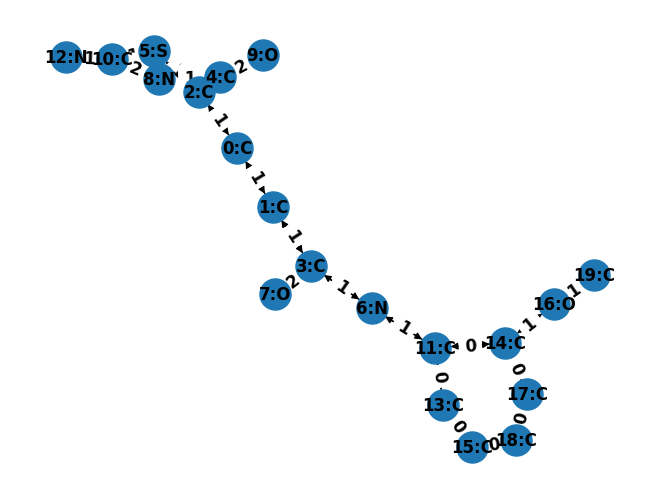

In [24]:
output, queue = full_generation()
graphX = torch_geometric_to_networkx(output)
plot_graph(graphX,  atom_conversion_type='onehot', encoding_type = 'reduced')

In [25]:
# Function that generate a desired number of molecules
def generate_molecules(n_molecules):
    molecules = []
    for i in range(n_molecules):
        output, queue = full_generation()
        graphX = torch_geometric_to_networkx(output)
        molecules.append(tensor_to_smiles(output.x, output.edge_index, output.edge_attr))
    return molecules

In [26]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import SVG

def draw_molecules(molecules):
    mols = [Chem.MolFromSmiles(m) for m in molecules]
    return Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), maxMols=50)

[10:37:16] Explicit valence for atom # 9 N, 4, is greater than permitted
[10:37:16] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[10:37:16] Can't kekulize mol.  Unkekulized atoms: 13 14 17
[10:37:16] Can't kekulize mol.  Unkekulized atoms: 4 11 12
[10:37:16] Can't kekulize mol.  Unkekulized atoms: 17 20 21 22 23 24 25


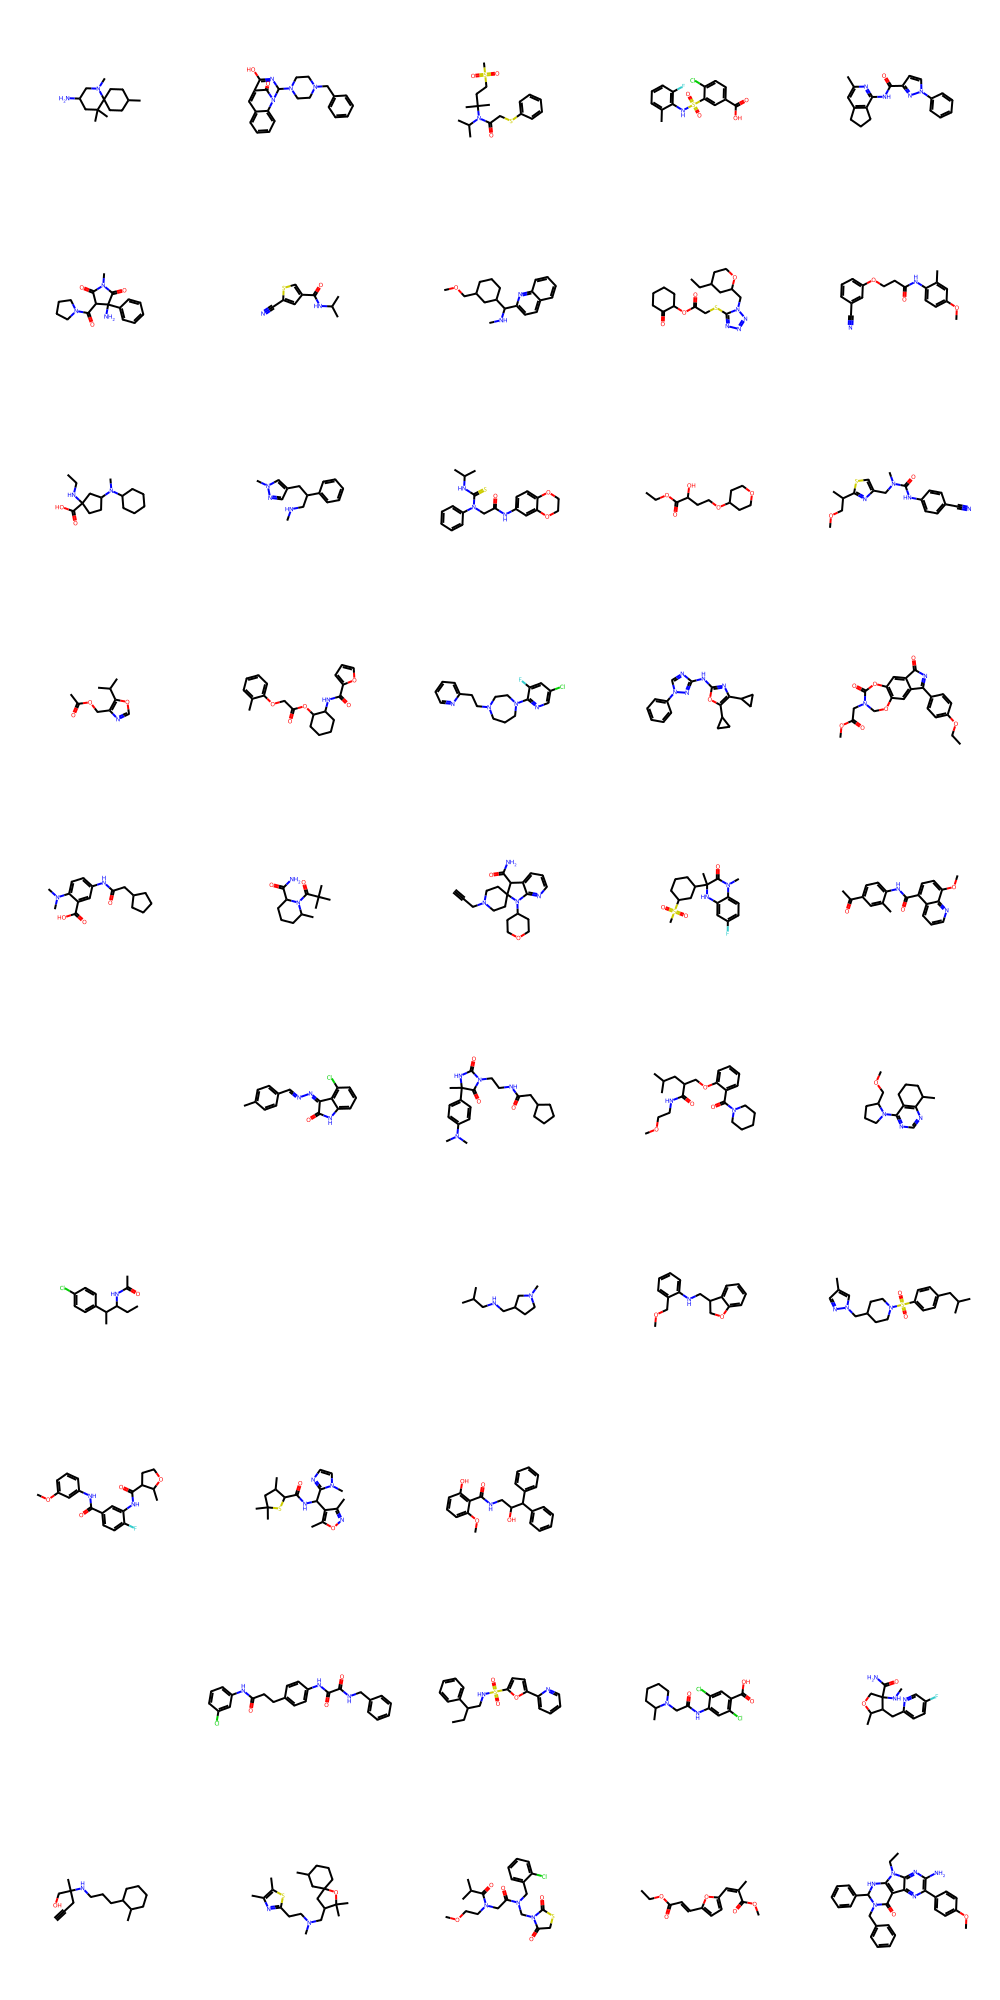

In [30]:
draw_molecules(generate_molecules(50))

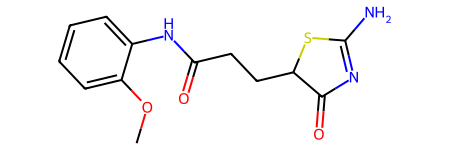

In [28]:
#plot the SMILES 
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

mol = Chem.MolFromSmiles(tensor_to_smiles(output.x, output.edge_index, output.edge_attr))
mol